In [1]:
using Distributions
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!
using Base.Iterators: repeated, partition
using LinearAlgebra: norm
using CounterfactualExplanations
using Distances
using BSON
using MLDatasets

include("../src/utils/train.jl")
include("../src/utils/plot.jl")
include("../src/utils/evaluate.jl")

evaluate_model (generic function with 1 method)

In [ ]:
CNN() = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10)) |> gpu

model = CNN();
loss(x, y) = logitcrossentropy(x, y)
opt = ADAM()

vanilla_losses = vanilla_train(model, loss, opt, X, y, 5, 32, 0, 9)

In [2]:
X, y = load_mnist()
X = (X .+ 1) ./ 2

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [3]:
X = reshape(X, 28, 28, 1, 60000)

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [4]:
X

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [5]:
size(X)

(28, 28, 1, 60000)

In [11]:
function margin_loss(logits, y)
    y = onehotbatch(y, 0:9) 
    preds_correct_class = sum(logits.*y, dims=1)
    diff = preds_correct_class .- logits
    diff[y] .= Inf
    margin = minimum(diff, dims=1)
    return margin
end

function cross_entropy_loss(logits, y; min_label=0, max_label=9)
    return -sum(onehotbatch(y, min_label:max_label) .* logsoftmax(logits; dims=1); dims=1)
end

cross_entropy_loss (generic function with 1 method)

In [7]:
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 397.789 KiB.

In [8]:
model = BSON.load("../src/models/MNIST/convnet_jaypmorgan.bson")[:model]

Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  BSON.__deserialized_types__.var"#16#17"(),
  Dense(288 => 10),                     # 2_890 parameters
)                   # Total: 8 arrays, 16_938 parameters, 67.578 KiB.

In [12]:
include("../src/utils/attacks.jl")

X_try = X[:, :, :, 10:19]
y_try = y[10:19]

# println(cross_entropy_loss(model(X_try), y_try))

FGSM(model, cross_entropy_loss, X_try, y_try)

Float32[3.2186456f-6 18.8151 20.204357 18.8151 20.843235 13.385318 15.984124 14.356504 13.81587 20.843235]
Float32[22.121649 1.1920922f-6 17.590004 1.1920922f-6 27.911737 14.016177 22.23383 16.625397 20.97243 27.911737]
Float32[14.055775 8.967764 0.00028618056 8.967764 13.470819 19.467815 22.992886 19.17251 8.781015 13.470819]
Float32[34.63959 -0.0 23.653736 -0.0 36.91339 30.532726 23.654139 23.427656 24.687426 36.91339]
Float32[17.486433 24.63553 20.09277 24.63553 6.4372807f-6 26.97621 32.43154 20.90731 18.63171 6.4372807f-6]
Float32[10.772942 14.690632 17.219296 14.690632 19.06264 8.773419f-5 11.517453 11.198164 10.103286 19.06264]
Float32[17.881329 13.354781 20.7696 13.354781 34.148346 15.671082 4.196079f-5 13.168868 16.127396 34.148346]
Float32[20.625975 13.263708 28.765596 13.263708 28.339998 19.819542 14.98256 2.503392f-6 15.552742 28.339998]
Float32[22.93911 14.746093 19.925953 14.746093 20.656704 22.599731 23.64119 15.450171 5.960463f-7 20.656704]
Float32[17.512144 17.882845 11

28×28×1×10 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0       0.3       …  0.3  0.3  0.0  0.0  0.0  0.3  0.3
 0.0  0.0  0.0  0.0  0.0       0.3          0.3  0.0  0.0  0.3  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.3          0.3  0.3  0.0  0.3  0.3  0.3  0.0
 0.3  0.0  0.3  0.0  0.0       0.3          0.0  0.3  0.0  0.0  0.3  0.3  0.3
 0.3  0.0  0.0  0.0  0.0       0.3          0.0  0.0  0.3  0.0  0.0  0.3  0.3
 0.3  0.3  0.3  0.3  0.0       0.0       …  0.0  0.0  0.3  0.0  0.0  0.3  0.3
 0.3  0.3  0.3  0.0  0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.3  0.0
 0.0  0.3  0.3  0.0  0.3       0.0          0.0  0.0  0.0  0.3  0.0  0.0  0.0
 0.3  0.0  0.3  0.0  0.0       0.0          0.3  0.3  0.0  0.0  0.3  0.3  0.3
 0.3  0.3  0.0  0.3  0.0       0.3          0.0  0.3  0.0  0.0  0.0  0.3  0.3
 ⋮                             ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0       0.3          0.3  0.0  0.0  0.0  0.3  0.0  0.3
 0.0  0.0  0.0  0.0  0

In [98]:
include("../src/utils/attacks.jl")

X_try = X[:, :, :, 10:19]
y_try = y[10:19]

# x_best, n_queries = SquareAttack(model, X_try, y_try, 5000, 0.8, 0.1, 0, 1, false)
x_best, η_list, checkpoints, starts_updated = AutoPGD(model, X_try, y_try, 100, 0.1, 0, 9, false;)

(Float32[0.0 0.0 … 0.2 0.2; 0.0 0.0 … 0.0 0.0; … ; 0.2 0.0 … 0.2 0.2; 0.2 0.0 … 0.0 0.2;;;; 0.0 0.0 … 0.2 0.2; 0.0 0.0 … 0.2 0.2; … ; 0.2 0.2 … 0.2 0.2; 0.2 0.0 … 0.0 0.2;;;; 0.0 0.0 … 0.0 0.2; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.2 … 0.0 0.0; 0.2 0.2 … 0.2 0.0;;;; 0.2 0.2 … 0.2 0.2; 0.2 0.2 … 0.0 0.0; … ; 0.2 0.0 … 0.0 0.2; 0.2 0.0 … 0.0 0.2;;;; 0.0 0.0 … 0.2 0.2; 0.0 0.0 … 0.2 0.2; … ; 0.0 0.2 … 0.0 0.0; 0.2 0.0 … 0.2 0.0;;;; 0.2 0.2 … 0.2 0.2; 0.2 0.2 … 0.2 0.2; … ; 0.0 0.0 … 0.0 0.0; 0.2 0.2 … 0.2 0.0;;;; 0.0 0.0 … 0.2 0.2; 0.2 0.0 … 0.2 0.2; … ; 0.0 0.2 … 0.0 0.0; 0.0 0.2 … 0.2 0.0;;;; 0.2 0.2 … 0.2 0.0; 0.2 0.2 … 0.2 0.2; … ; 0.2 0.0 … 0.0 0.0; 0.0 0.0 … 0.2 0.0;;;; 0.2 0.2 … 0.0 0.0; 0.2 0.2 … 0.0 0.0; … ; 0.0 0.2 … 0.0 0.0; 0.0 0.0 … 0.2 0.0;;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 0.5961693 1.0; … ; 0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], Any[[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2

In [99]:
# checkpoints
η_list
# starts_updated

100-element Vector{Any}:
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
 ⋮
 [0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125]
 [0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125, 0.003125]
 [0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625]
 [0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625, 0.0015625]
 [0.0015625, 0.0015625, 

In [65]:
n_queries

10-element Vector{Float64}:
  269.0
  350.0
  164.0
 1368.0
  381.0
  931.0
  154.0
  335.0
  643.0
  173.0

In [51]:
worked = findall(x -> x > 1.0 && x < 5001.0, n_queries)
worked

3-element Vector{Int64}:
  1
  7
 10

In [52]:
# x_topass = reshape(x_best, 784, 10)
logits = model(x_best)

10×10 Matrix{Float32}:
  -6.4244    -6.35596  -1.71608  …   -5.06284    7.6024    -7.29887
  -1.56402   -8.0082   -2.96609      -2.4279    -7.03833   -2.36438
   0.773059   2.73639  -1.69197      -1.81789   -1.0983     7.8228
   0.1392     6.2367    6.50094      -1.46008   -4.3157     1.95998
  -5.20939   -5.91986  -9.66909      -1.47265   -4.64143   -1.63827
  -6.53583   -8.47914  -4.29433  …   -2.13736   -7.71442  -10.8716
 -11.1885    -5.20206  -5.88469       5.18527    6.06272  -14.6501
   3.78584   -1.99419  -7.59177     -13.559    -11.6048     7.78535
  -1.25803    3.5427    8.4769        4.24041   -3.23628   -3.16118
   3.8737    -7.78008  -4.6648       -8.36679   -4.56624   -8.0269

In [41]:
y[30:39]

10-element Vector{Int64}:
 7
 3
 8
 6
 9
 0
 5
 6
 0
 7

In [53]:
fooled = findall(x -> x > 0.1, cross_entropy_loss(logits, y[30:39]))

8-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(1, 3)
 CartesianIndex(1, 4)
 CartesianIndex(1, 5)
 CartesianIndex(1, 7)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)
 CartesianIndex(1, 10)

In [43]:
cross_entropy_loss(logits, y[30:39])

1×10 Matrix{Float32}:
 0.872024  1.89096  0.776092  1.41181  …  0.80854  1.51745  1.05749  3.50268

In [44]:
size(fooled)

(10,)

In [84]:
difference = x_best[:, :, :, idx] - X_try[:, :, :, idx]
extrema(difference)

(-0.6f0, 0.6f0)

Digit predicted by the model for the clean image: 8
Digit predicted by the model for the 
    adversarial image: 8
True label: 8


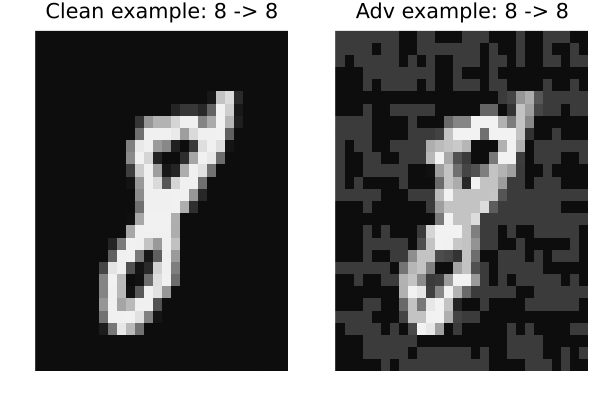

In [109]:
include("../src/utils/plot.jl")

idx = 9
# difference = x_best[:, :, :, idx] - X_try[:, :, :, idx]
clean_pred_label = (model(X_try[:, :, :, idx:idx]) |> onecold |> getindex) - 1
adv_pred_label = (model(x_best[:, :, :, idx:idx]) |> onecold |> getindex) - 1
true_label = y_try[idx]
plot_mnist_image(x_best[:, :, :, idx], X_try[:, :, :, idx], clean_pred_label, adv_pred_label, true_label)